In [109]:
# Librerias
import os
from bs4 import BeautifulSoup, NavigableString
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re
from threading import Thread
import queue

In [110]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "5"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [111]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  #if tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }) is not None: 
  #  print(parseNames(parseLineBreaksAndAccents(tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }).text)))
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [112]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  print("Archivos originales: " + str(len(files)))

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  print("Archivos filtrados solo con postulaciones: " + str(len(filesFiltered)))

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(196).html"
    #r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador.NET_(1).html"
    #r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador. Net_(26).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-5\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
  ]

  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = 1000
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [113]:
def getEncodingBumeran(file):
  candidateLog = ""

  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      candidateLog = candidateLog + file + "\n"
      candidateLog = candidateLog + traceback.format_exc() + "\n"
      candidateLog = candidateLog + "\n"
      pass
      
  return encoding, candidateLog

In [114]:
def getCandidateBumeran(file, encoding, candidateLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%Y-%m-%d %H:%M")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      #candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      """
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      candidateData["secondLineParsed"] = secondLineParsed
      
      # Pais de residencia
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:])
      

      # Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = ""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]

      #Dirección
      fifthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[4].text))
      candidateData["candidateAddress"] = fifthLineParsed
      
      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[5].text))
      #candidateData["contactNumber"] = sixthLineParsed
      #candidateData["slash"] = sixthLineParsed
      #candidateData["regex"] = re.sub("[^0-9/]", "", sixthLineParsed)
      
      candidateData["homeNumber"] = sixthLineParsed[sixthLineParsed.find("Tel.")+5:sixthLineParsed.find("/")]
      candidateData["cellphoneNumber"] = sixthLineParsed[sixthLineParsed.find("/")+2:]

      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[6].text))
      candidateData["email"] = sixthLineParsed
      """

      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)
      #print(len(mainChildTags))
      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)
      #print(sectionsIndexes)

      # Objetivo laboral, salario
      """
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)
      if startIndex and endIndex:
        if (endIndex - startIndex) == 3:
          workObjectiveTag = mainChildTags[startIndex+2]
          candidateData["workObjetive"] = ""
          candidateData["salary"] = -1
          liTags = workObjectiveTag.find_all("li")
          for liTag in liTags:
            parsedText = parseNames(parseLineBreaksAndAccents(liTag.text))
            if "Objetivo Laboral:" in parsedText:
              candidateData["workObjetive"] = parsedText[parsedText.find("Objetivo Laboral: ")+18:]
            if "Sueldo Pretendido:" in parsedText:
              candidateData["salary"] = int(parsedText[parsedText.find("$")+1:parsedText.find(".")])
        else:
          candidateData["workObjetive"] = ""
          candidateData["salary"] = -1
      else:
        candidateData["workObjetive"] = ""
        candidateData["salary"] = -1
      """
      
      # Experiencia laboral
      """startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        
        # Iterando sobre todos los trabajos
        daysOfExperience = 0
        for index, firstRowIndex in enumerate(range(0, len(workExperienceTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex+1].find("p").findAll(string=True)]
          workStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          workStartDate = datetime.datetime.strptime(workStartDateText, "%d-%m-%Y")
          workEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          workEndDate = datetime.datetime.strptime(workEndDateText, "%d-%m-%Y") if workEndDateText != "Presente" else postulationDate
          daysOfWork = (workEndDate - workStartDate).days
          daysOfExperience = daysOfExperience + daysOfWork
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastWorkDays"] = daysOfWork
            candidateData["lastWorkCompany"] = firstRowTagsValues[1]
            candidateData["lastWorkCountry"] = firstRowTagsValues[2][:firstRowTagsValues[2].find(".")]
            candidateData["lastWorkArea"] = firstRowTagsValues[2][firstRowTagsValues[2].find(".")+2:firstRowTagsValues[2].rfind(".")]
            candidateData["lastWorkName"] = secondRowTagsValues[0]
            candidateData["lastWorkDescription"] = secondRowTagsValues[1]
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        raise Exception("561 errores mapeados (experiencia laboral)")"""
      
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)
      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]

        #['01-05-2016 - 01-07-2016 |', 'Galaxy Training', ', Peru.', 'Programacion', '.']
        #['Arquitectura De Aplicaciones Java Ee', ', Graduado, Otro.']

        # Iterando sobre todos las educaciones
        daysOfStudy = 0
        for index, firstRowIndex in enumerate(range(0, len(educationTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex].find("span").findAll(string=True)]
          print(firstRowTagsValues)
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex+1].find("p").findAll(string=True)]
          print(secondRowTagsValues)
          educationStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          educationStartDate = datetime.datetime.strptime(educationStartDateText, "%d-%m-%Y")
          educationEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          educationEndDate = datetime.datetime.strptime(educationEndDateText, "%d-%m-%Y") if educationEndDateText != "Presente" else postulationDate
          daysOfEducation = (educationEndDate - educationStartDate).days
          daysOfStudy = daysOfStudy + daysOfEducation
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastEducationDays"] = daysOfEducation
            candidateData["lastEducationCompany"] = firstRowTagsValues[1]
            candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
            candidateData["lastEducationArea"] = firstRowTagsValues[3]
            candidateData["lastEducationName"] = secondRowTagsValues[0]
            candidateData["lastEducationStatus"] = secondRowTagsValues[1][secondRowTagsValues[1].find(",")+2:secondRowTagsValues[1].rfind(",")]
            candidateData["lastEducationDegree"] = secondRowTagsValues[1][secondRowTagsValues[1].rfind(",")+2:secondRowTagsValues[1].find(".")]
        candidateData["yearsOfStudy"] = int(daysOfStudy/365)
        candidateData["studiesNumber"] = int(len(educationTags)/2)
        candidateData["tags"] = len(educationTags)
      else:
        raise Exception("121 errores mapeados (educación)")
      
      """
      
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        
        careerTags0 = educationTags[0].find_all("b")
        candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
        candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

        careerTags1 = educationTags[1].find_all("span")
        tempText = careerTags1[len(careerTags1)-2].text
        candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.find(",")+2:tempText.rfind(",")]))
        candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.rfind(",")+2:tempText.rfind(".")]))
        candidateData["studiesNumber"] = int(len(educationTags)/2)

        if (candidateData["studyCenter"] == "" or candidateData["careerField"] == "" or candidateData["careerStatus"] == "" or candidateData["careerDegree"] == ""):
          raise Exception("Error no mapeado (educación)")
      else:
        raise Exception("121 errores mapeados (educación)")

      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)
      else:
        raise Exception("Errores no mapeados (habilidades técnicas)")

      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)
      else:
        raise Exception("Errores no mapeados (lenguajes)")

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        raise Exception("Errores no mapeados (otras habilidades)")

      # Pendiente de analizar casos fraccionarios (se trunco para caso práctico)

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(rawSalary[rawSalary.find("$")+1:rawSalary.find(".")])
      else:
        raise Exception("Errores no mapeados (salario)")
        """

  except Exception as e:
    candidateData = {}
    candidateLog = candidateLog + str(file) + "\n"
    candidateLog = candidateLog + traceback.format_exc() + "\n"
    candidateLog = candidateLog + "\n"
    pass

  return candidateData, candidateLog

In [115]:
class Worker(Thread):
  def __init__(self, queue, filesCount):
    Thread.__init__(self)
    self.queue = queue
    self.filesCount = filesCount
    self.candidateData = []
    self.candidateLog = []

  def run(self):
    while True:
      elem = self.queue.get()
      if not elem:
        break
      
      index, file = elem["index"], elem["file"]

      if index % 500 == 0:
        print(str(index) + "/" + str(self.filesCount) + " archivos analizados")
      
      # Obteniendo el encoding por cada archivo
      encoding, candidateLog = getEncodingBumeran(file)

      # Obteniendo los datos por cada archivo
      candidateData, candidateLog = getCandidateBumeran(file, encoding, candidateLog)
      
      if candidateData:
        self.candidateData.append(candidateData)
      if candidateLog:
        self.candidateLog.append(candidateLog)

      self.queue.task_done()

In [116]:
def iterateCandidateQueue(files, workersNumber):
  filesCount = len(files)

  q = queue.Queue()
  for index, file in enumerate(files):
    q.put({"index": index, "file": file})
  
  for _ in range(workersNumber):
    q.put({})
  
  workers = []
  for _ in range(workersNumber):
      worker = Worker(q, filesCount)
      worker.start()
      workers.append(worker)
  
  for worker in workers:
      worker.join()
  
  data = []
  log = ""
  for worker in workers:
    data.extend(worker.candidateData)
    log = log + "".join(worker.candidateLog)

  return data, log

In [117]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Definiendo el numero de hilos
  workersNumber = 1

  # Obteniendo los datos de candidatos y el log
  data, log = iterateCandidateQueue(files, workersNumber)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  #data = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(log, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [118]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [119]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]]

  for column in columns:
    topDf = df[column].value_counts()[:dataVisualizationTopLimit]
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-19 10:57:31.180860
Se inició el procesamiento
Archivos originales: 10230
Archivos filtrados solo con postulaciones: 10228
Archivos filtrados solo con data completa: 10225
0/1000 archivos analizados
['01-11-2010 - 01-07-2016 |', 'Universidad De Oriente', ', Venezuela.', 'Ing. En Sistemas', '.']
['Ingeniero De Sistemas', ', Graduado, Universitario.']
['01-01-2011 - 01-12-2016 |', 'Universidad Nacional De San Antonio Abad Del Cusco', ', Peru.', 'Computacion / Informatica', '.']
['Ingenieria Informatica Y De Sistemas', ', Graduado, Universitario.']
['01-01-2018 - 01-02-2018 |', 'Senati - Programa Nacional De Informatica', ', Peru.', 'Tecnico', '.']
['Lenguaje De Programacion:Genexus', ', Graduado, Otro.']
['01-01-2015 - 01-12-2017 |', 'Senati - Programa Nacional De Informatica', ', Peru.', 'Computacion / Informatica', '.']
['Desarrollo De Software (Programacion)', ', Graduado, Terciario/Tecnico.']
['01-05-2016 - 01-10-2019 |', 'Instituto Superior Sise', ', Peru.', 'Tecnolog

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_21128\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


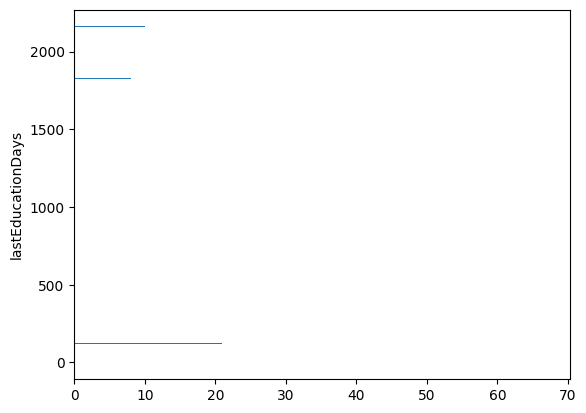

Universidad Tecnologica Del Peru             48
Universidad Peruana De Ciencias Aplicadas    40
Pontificia Universidad Catolica Del Peru     39
Universidad Privada Del Norte                36
Universidad Nacional Mayor De San Marcos     34
Universidad De Lima                          27
Universidad De San Martin De Porres          27
Utp                                          26
Universidad Cesar Vallejo                    25
Upc                                          24
Cibertec                                     22
Universidad Ricardo Palma                    19
Universidad Nacional De Ingenieria           19
Universidad Esan                             19
Instituto Cibertec                           15
Tecsup                                       14
Universidad Nacional Del Callao              14
Universidad Alas Peruanas                    12
Universidad Nacional Federico Villarreal     12
Universidad San Ignacio De Loyola            10
Name: lastEducationCompany, dtype: int64

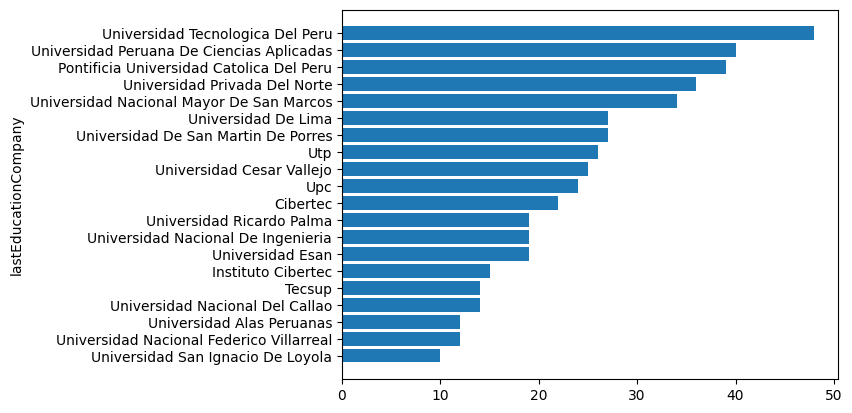

Peru              935
Espana             14
Estados Unidos     12
Venezuela          10
Colombia            3
Mexico              2
Brasil              1
Francia             1
Canada              1
Costa Rica          1
Argentina           1
Italia              1
Name: lastEducationCountry, dtype: int64


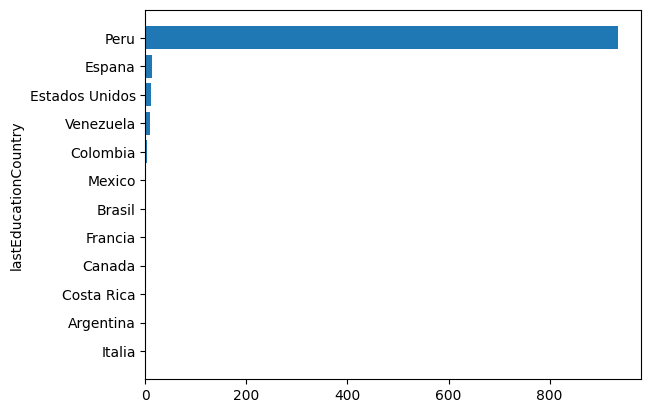

Ing. En Sistemas                 324
Tecnologias De La Informacion    114
Ing. Industrial                   95
Adm. De Empresas                  80
Ing. Informatica                  75
Computacion / Informatica         36
Analisis De Sistemas              31
Procesos / Calidad Total          28
Ing. - Otros                      26
Otra                              22
Contabilidad / Auditoria          12
Finanzas                          10
Programacion                       9
Marketing / Comercializacion       8
Interprete                         6
Arquitectura                       6
Telecomunicaciones                 6
Adm. Y Gestion Publica             6
Economia                           5
Ing. Telecomunicaciones            5
Name: lastEducationArea, dtype: int64


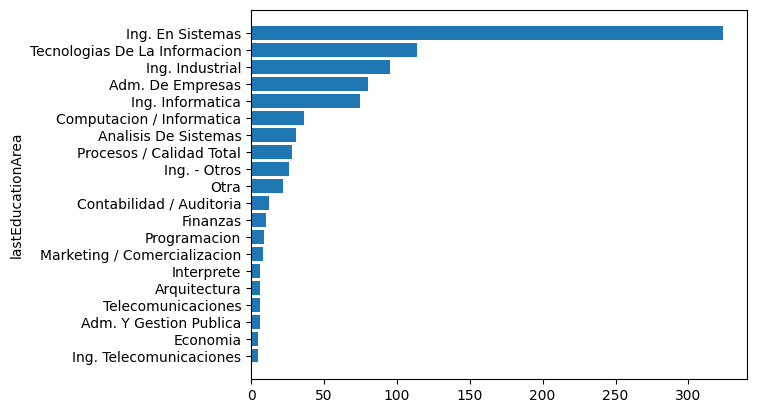

Ingenieria De Sistemas                       115
Ingenieria Industrial                         47
Ingenieria De Sistemas E Informatica          21
Ingenieria De Sistemas De Informacion         16
Computacion E Informatica                     14
Ingenieria De Computacion Y Sistemas          12
Ingeniera De Sistemas                         11
Ingenieria Informatica                        11
Administracion De Empresas                    10
Gestion De Proyectos                           9
Bachiller En Ingenieria De Sistemas            9
Ingenieria De Sistemas Computacionales         9
Ingeniero De Sistemas E Informatica            8
Scrum Master                                   7
Ingeniero De Sistemas                          7
Istqb Certified Tester - Foundation Level      7
Ingenieria Empresarial                         6
Bachiller                                      6
Ingles                                         6
Ingeniero De Computacion Y Sistemas            6
Name: lastEducationN

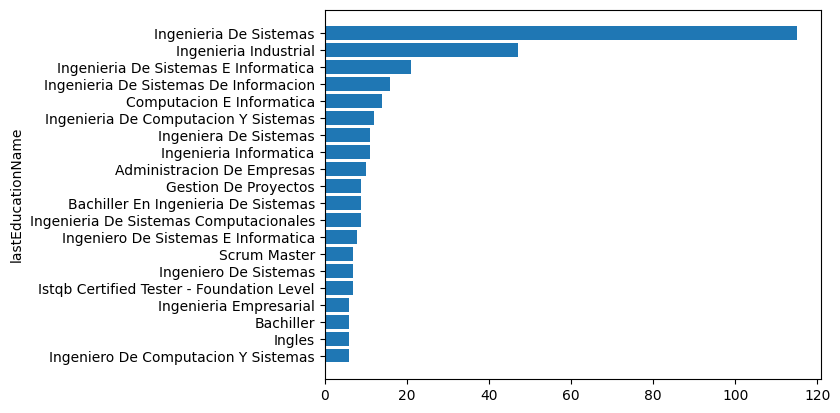

Graduado      728
En Curso      236
Abandonado     18
Name: lastEducationStatus, dtype: int64


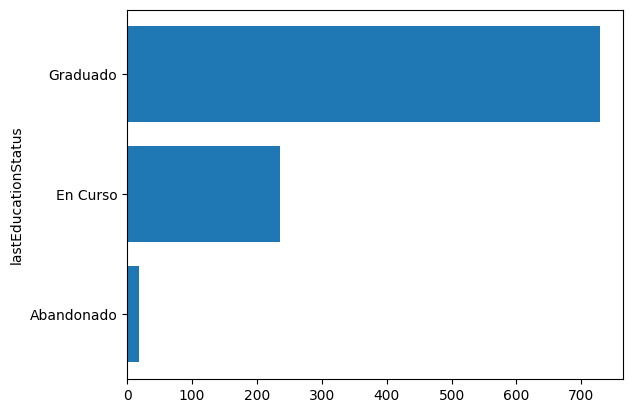

Universitario        493
Otro                 219
Posgrado             130
Terciario/Tecnico     81
Master                58
Secundario             1
Name: lastEducationDegree, dtype: int64


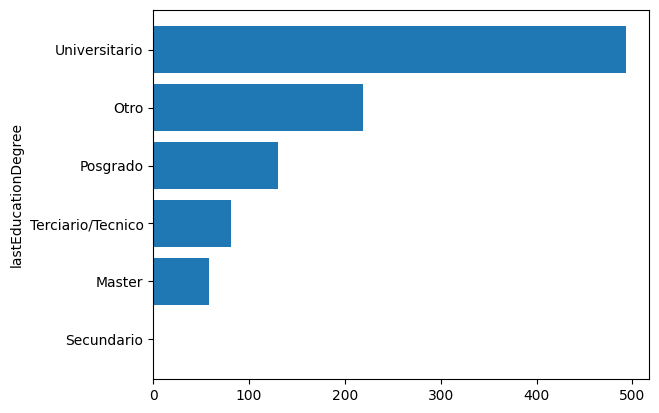

5     185
7     148
6     134
4     112
8      85
9      57
10     46
3      43
11     24
13     24
2      15
12     14
16     13
14     13
1      10
15      9
18      9
19      8
0       7
20      6
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_21128\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


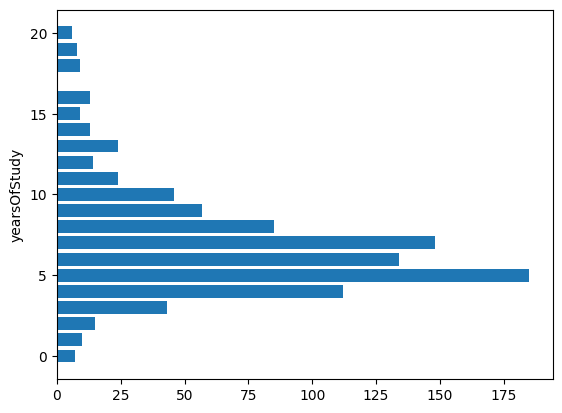

1     371
2     213
3      94
4      70
5      59
6      45
7      28
8      22
11     18
9      13
12      8
14      7
10      7
13      5
15      4
28      4
36      2
26      2
25      1
24      1
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_21128\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


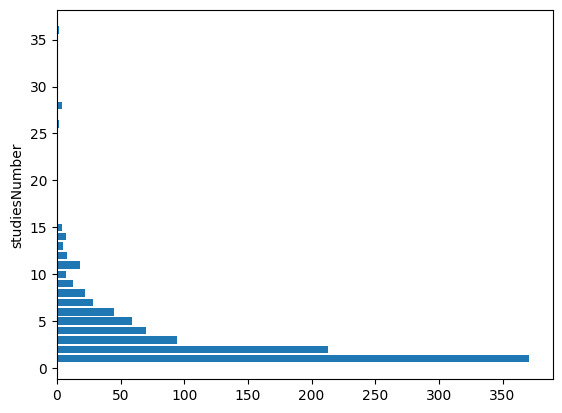

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_21128\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


2     371
4     213
6      94
8      70
10     59
12     45
14     28
16     22
22     18
18     13
24      8
28      7
20      7
26      5
30      4
56      4
72      2
52      2
50      1
48      1
Name: tags, dtype: int64


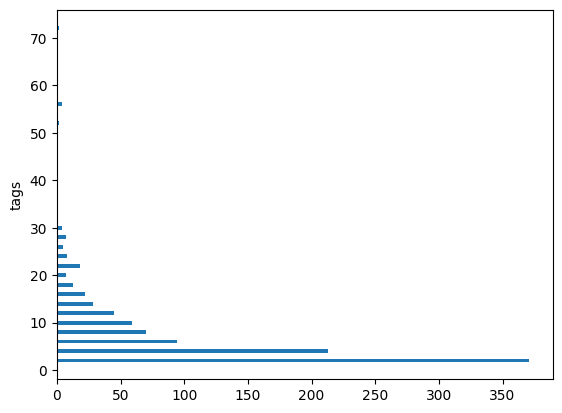

Fin: 2023-05-19 10:58:10.760070
Tiempo: 0:00:39.579210


In [120]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Uniendo la data principal (bumeran + linkedin (ya no))
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()